In [60]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torchvision import transforms
import torchvision
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
path = '/content/drive/My Drive/optimizer/'

cuda


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
### DPLM
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

class TwoLayerMLP(nn.Module):
    def __init__(self,nonlinear_dim,hidden_neuron):
        super(TwoLayerMLP, self).__init__()
        torch.manual_seed(218)
        torch.cuda.manual_seed(218)
        self.layers = nn.Sequential(
        nn.Linear(nonlinear_dim, hidden_neuron),
        nn.ReLU(),
        nn.Linear(hidden_neuron, 1, bias=False),
        )
        with torch.no_grad():
            self.layers[0].weight=nn.Parameter(nn.init.normal_(torch.empty(hidden_neuron, nonlinear_dim),0,1/hidden_neuron))
            self.layers[2].weight=nn.Parameter(nn.init.uniform_(torch.empty(1,hidden_neuron),-1,1))

    def forward(self, x2):
        x = self.layers(x2)
        return x

# Dataset

## Mnist

In [14]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=True, 
                                          transform=transforms.ToTensor(),  
                                          download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())
# sampler
torch.manual_seed(218)
sampler=torch.utils.data.SubsetRandomSampler(np.array(range(600)))
# Data loader
trainloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=len(train_dataset), 
                                          sampler=sampler)

testloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=len(test_dataset), 
                                          shuffle=False)

#### small mnist

In [63]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=True, 
                                          transform=transforms.ToTensor(),  
                                          download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())
# sampler
torch.manual_seed(218)
sampler=torch.utils.data.SubsetRandomSampler(np.array(range(60)))
# Data loader
trainloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=len(train_dataset), 
                                          sampler=sampler)

testloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=len(test_dataset), 
                                          shuffle=False)

## Synthetic data

In [ ]:
y_train = training[1]
X_train = training[0]

y_test = testing[1]
X_test = testing[0]


if batch_size==None:
    batch_size=y_train.shape[0]
    
Train_dataset = TensorDataset(y_train,X_train)
trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)
Test_dataset = TensorDataset(y_test,X_test)
testloader = DataLoader(dataset=Test_dataset, batch_size=y_test.shape[0], shuffle=False)

In [ ]:
#%% 2 linear features, 1 non-linear feature, small sample size enough; more sample better

n=50
np.random.seed(1)

x1 = np.random.randn(n,1)
x2 = np.random.randn(n,1)
x3 = np.linspace(-4,4,n).reshape(n,1)
y = -x1*0.5+1.2*x2+np.sin(x3)*10
X_train=torch.tensor(np.concatenate([x1,x2,x3],axis=1)).float()
y_train=torch.tensor(y).float()
train=[X_train,y_train]

# Higher_SGD (new optimizer)

In [15]:
import torch
from torch.optim import Optimizer #, required


class Higher_SGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).
    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf
    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.
        Considering the specific case of Momentum, the update can be written as
        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + g_{t+1}, \\
                p_{t+1} & = p_{t} - \text{lr} * v_{t+1},
            \end{aligned}
        where :math:`p`, :math:`g`, :math:`v` and :math:`\mu` denote the 
        parameters, gradient, velocity, and momentum respectively.
        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form
        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + \text{lr} * g_{t+1}, \\
                p_{t+1} & = p_{t} - v_{t+1}.
            \end{aligned}
        The Nesterov version is analogously modified.
    """

    def __init__(self, params, lr, momentum=0,momentum2=0, dampening=0,
                 weight_decay=0, nesterov=False):
        # if lr is not required and lr < 0.0:
            # raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum,momentum2=momentum2, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(Higher_SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Higher_SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            momentum2 = group['momentum2']
            dampening = group['dampening']
            nesterov = group['nesterov']
            a = 1/2*(momentum+np.sqrt(momentum**2+4*momentum2))
            b = 1/2*(momentum-np.sqrt(momentum**2+4*momentum2))
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer_q' not in param_state:
                        buf_q = param_state['momentum_buffer_q'] = torch.clone(d_p*0).detach()
                    else:
                        buf_q = param_state['momentum_buffer_q']
                        buf_q.mul_(b).add_(d_p, alpha=1)
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(a).add_(buf_q, alpha=1)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(d_p, alpha=-group['lr'])

        return loss

# Training

In [69]:
def NTK_torch(opt_name,
              hidden_neuron=100,epochs=10,lr=1e-3,
              batch_size=None,nesterov_r=None, momentum=None, momentum2=None, 
              save=False, trainloader=trainloader, testloader=testloader):
  
    loss_record=[]
    torch.manual_seed(218)
    torch.cuda.manual_seed(218)

    model = TwoLayerMLP(28*28, hidden_neuron).to(device) #X_train.shape[1]

    if 'nesterov' in opt_name:
        print('Training with nesterov')
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                                    nesterov=True,momentum = nesterov_r)
    elif 'heavyball' in opt_name:
        print('Training with heavyball')
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                                    momentum = momentum)
    elif 'higherm' in opt_name:
        print('Training with higher momentum')
        optimizer = Higher_SGD(model.parameters(),lr = lr, 
                          momentum=momentum, momentum2=momentum2)
    else:
        print('Training with GD')
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    criterion = nn.MSELoss()
    # old_val_error=1e12
    # patience_current=0

    for epoch in range(1,epochs+1):
        if nesterov_r!=None:
            for param_group in optimizer.param_groups:
                param_group['momentum'] = (epoch-1)/(epoch+nesterov_r-1)

        for batch_x,batch_y in trainloader:
            optimizer.zero_grad()
            batch_x = batch_x.view(-1, 28*28).float().to(device)
            batch_y = batch_y.view(-1, 1).float().to(device)
            batch_y_pred = model(batch_x)
            batch_loss = criterion(batch_y_pred, batch_y) #batch_y_pred, batch_y.reshape(-1, 1)
            batch_loss.backward()
            optimizer.step()
        if epoch%1000==0:
            print(epoch, '---', batch_loss.cpu().detach().numpy())
        loss_record.append(batch_loss.cpu().detach().numpy())
        # with torch.no_grad():
        #     for test_x,test_y in testloader:
        #         test_x = test_x.view(-1, 28*28).float().to(device)
        #         test_y = test_y.view(-1, 1).float().to(device)
        #         test_y_pred = model(test_x)
        #         val_loss = criterion(test_y_pred, test_y)
                # print(epoch, '---', val_loss.numpy())
                # loss_record.append(val_loss.numpy())
    
        if save == True:
            path = '/content/drive/My Drive/optimizer/'
            torch.save(loss_record, path+f"{lr}"+f"{opt_name}.pt")
            #print("save successfully!")
      
    return loss_record

## Gradient Descent (GD)

In [20]:
import time
torch.manual_seed(1)
gd_loss=NTK_torch(opt_name='gd', hidden_neuron=3000,epochs=5000,lr=1e-4,save=True)
print('time spent: ', time.time()-start)

Training with GD
100 --- 2.2234924
200 --- 1.6855325
300 --- 1.360984
400 --- 1.1410167
500 --- 0.979374
600 --- 0.85582834
700 --- 0.75786716
800 --- 0.67798984
900 --- 0.61157966
1000 --- 0.5551818
1100 --- 0.5068956
1200 --- 0.46497875
1300 --- 0.4281652
1400 --- 0.39561322
1500 --- 0.36669892
1600 --- 0.3409455
1700 --- 0.31779987
1800 --- 0.29689628
1900 --- 0.27794072
2000 --- 0.2607047
2100 --- 0.24497381
2200 --- 0.23058589
2300 --- 0.2173759
2400 --- 0.205228
2500 --- 0.19396512
2600 --- 0.18355498
2700 --- 0.17389794
2800 --- 0.1649143
2900 --- 0.15655318
3000 --- 0.14878424
3100 --- 0.1415073
3200 --- 0.13471504
3300 --- 0.1283311
3400 --- 0.122349195
3500 --- 0.11674694
3600 --- 0.11146513
3700 --- 0.10651656
3800 --- 0.10185198
3900 --- 0.09743811
4000 --- 0.09328677
4100 --- 0.08936261
4200 --- 0.08563365
4300 --- 0.082116306
4400 --- 0.078792
4500 --- 0.07562423
4600 --- 0.072627984
4700 --- 0.0697774
4800 --- 0.067068525
4900 --- 0.06448632
5000 --- 0.062027577


## Heavy ball (HB)

### HB v.s width

In [179]:
start = time.time()
momentum_list = [0,0.6,0.9] #0 is 5500; 0.6 is 4500; 0.9 is 3500
width_list = np.arange(2000,8500,500)

hb_loss = np.ones(((len(momentum_list), len(width_list))))
for i in range(len(momentum_list)):
    for j in range(len(width_list)):
        temp = NTK_torch(opt_name='heavyball_'+str(momentum_list[i]), 
                         hidden_neuron=width_list[j],epochs=200,lr=5e-5,
                         momentum = momentum_list[i])
        print(momentum_list[i], width_list[j], temp[-1])
        hb_loss[i, j] = temp[-1]

path = '/content/drive/My Drive/optimizer/'
torch.save(hb_loss, path+f"{'hb_total_width'}.pt")

print('time spent: ', time.time()-start)


Training with heavyball
100 --- 2.7269366
200 --- 2.195019
0 2000 2.195019
Training with heavyball
100 --- 2.6287277
200 --- 2.1045213
0 2500 2.1045213
Training with heavyball
100 --- 2.565497
200 --- 2.0404272
0 3000 2.0404272
Training with heavyball
100 --- 2.4964576
200 --- 1.9850847
0 3500 1.9850847
Training with heavyball
100 --- 2.397992
200 --- 1.8996814
0 4000 1.8996814
Training with heavyball
100 --- 2.3258305
200 --- 1.8242241
0 4500 1.8242241
Training with heavyball
100 --- 2.3061287
200 --- 1.8059024
0 5000 1.8059024
Training with heavyball
100 --- 2.2477913
200 --- 1.7468506
0 5500 1.7468506
Training with heavyball
100 --- 2.2706778
200 --- 1.7487049
0 6000 1.7487049
Training with heavyball
100 --- 2.2755368
200 --- 1.749634
0 6500 1.749634
Training with heavyball
100 --- 2.3556733
200 --- 1.8361844
0 7000 1.8361844
Training with heavyball
100 --- 2.4592257
200 --- 1.9426382
0 7500 1.9426382
Training with heavyball
100 --- 2.7000272
200 --- 2.1390553
0 8000 2.1390553
Train

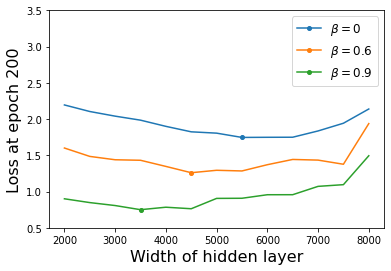

In [57]:
#%%
hb_loss_total = torch.load(path+f"{'hb_total_width'}.pt")
# plt.xscale('log')
momentum_list = [0,0.6,0.9]
width_list = np.arange(2000,8500,500)
# markers_on = [j==3000 for j in y]


for i in range(len(momentum_list)):
    np.argmin(hb_loss_total[i, :])
    plt.plot(width_list, hb_loss_total[i, :], 
             'o', ls='-', ms=4,
             label = r'$\beta=$'+str(momentum_list[i]),
             markevery=[j==width_list[np.argmin(hb_loss_total[i, :])] for j in width_list])
plt.xlabel('Width of hidden layer', fontsize=16)
plt.ylabel('Loss at epoch 200', fontsize=16)
# plt.xlim(8e-5, 1e-4)
plt.ylim(0.5,3.5)
plt.legend(fontsize=12)
plt.savefig(path+'HB_Width.pdf', bbox_inches = 'tight')
plt.show() 

### HB v.s epoch

In [32]:
import time
start = time.time()
hb_loss0=NTK_torch(opt_name='heavyball_2', hidden_neuron=3000,epochs=5000,lr=1e-4,momentum=0.2, save=True)
hb_loss1=NTK_torch(opt_name='heavyball_5', hidden_neuron=3000,epochs=5000,lr=1e-4,momentum=0.5, save=True)
hb_loss2=NTK_torch(opt_name='heavyball_8', hidden_neuron=3000,epochs=5000,lr=1e-4,momentum=0.8, save=True)
print('time spent: ', time.time()-start)

Training with heavyball
1 --- 30.273016
2 --- 747870.6
3 --- 43.24715
4 --- 20.301891
5 --- 11.818008
6 --- 9.175101
7 --- 8.752445
8 --- 8.128268
9 --- 7.661182
10 --- 7.2237663
11 --- 6.824565
12 --- 6.457968
13 --- 6.123602
14 --- 5.8213673
15 --- 5.5512424
16 --- 5.3128996
17 --- 5.1054764
18 --- 4.927359
19 --- 4.7755537
20 --- 4.6465807
21 --- 4.5369563
22 --- 4.443264
23 --- 4.3623734
24 --- 4.291888
25 --- 4.2297378
26 --- 4.174005
27 --- 4.1235833
28 --- 4.0773783
29 --- 4.0344896
30 --- 3.9940686
31 --- 3.9559019
32 --- 3.9195957
33 --- 3.8847413
34 --- 3.8509343
35 --- 3.8184078
36 --- 3.7870903
37 --- 3.7568438
38 --- 3.727588
39 --- 3.699281
40 --- 3.6718605
41 --- 3.6452324
42 --- 3.619346
43 --- 3.5942383
44 --- 3.569838
45 --- 3.5461524
46 --- 3.5231557
47 --- 3.5008175
48 --- 3.4790912
49 --- 3.4579258
50 --- 3.4373307
time spent:  2.2765257358551025


In [26]:
hb_loss0 = torch.load(path+f"{'0.0001heavyball_2'}.pt")
hb_loss1 = torch.load(path+f"{'0.0001heavyball_5'}.pt")
hb_loss2 = torch.load(path+f"{'0.0001heavyball_8'}.pt")
gd_loss = torch.load(path+f"{'0.0001gd'}.pt")

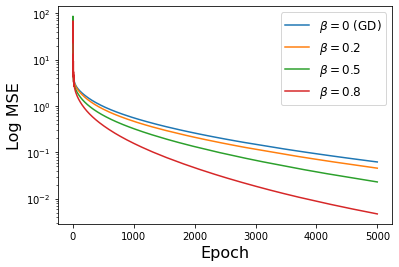

In [56]:
#%%
plt.yscale('log')
plt.plot(gd_loss, label=r'$\beta=0$ (GD)') 
plt.plot(hb_loss0, label=r'$\beta=0.2$') #HB02
plt.plot(hb_loss1, label=r'$\beta=0.5$') #HB05
plt.plot(hb_loss2, label=r'$\beta=0.8$') #HB08
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Log MSE', fontsize=16)
plt.legend(fontsize=12)
plt.savefig(path+'HB_Epoch.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
print((np.log(hb_loss0[999])-np.log(hb_loss0[990]))/9)
print((np.log(hb_loss1[99])-np.log(hb_loss1[90]))/9)
print((np.log(hb_loss2[99])-np.log(hb_loss2[90]))/9)

-0.0007571511798434787
-0.0020769304699367946
-0.002375748422410753


## Nesterov (NAG)

### NAG v.s width

In [36]:
start = time.time()
nesterov_r_list = [2, 4, 10] 
width_list = np.arange(1000,9000,1000)

nag_loss = np.ones(((len(nesterov_r_list), len(width_list))))
for i in range(len(nesterov_r_list)):
    for j in range(len(width_list)):
        temp = NTK_torch(opt_name='nesterov_'+str(nesterov_r_list[i]), 
                         hidden_neuron=width_list[j],epochs=200,lr=5e-5,
                         nesterov_r = nesterov_r_list[i])
        print(nesterov_r_list[i], width_list[j], temp[-1])
        nag_loss[i, j] = temp[-1]

path = '/content/drive/My Drive/optimizer/'
torch.save(nag_loss, path+f"{'nag_total_width'}.pt")

print('time spent: ', time.time()-start)

Training with nesterov
100 --- 0.73903596
200 --- 0.15333293
2 1000 0.15333293
Training with nesterov
100 --- 0.5192177
200 --- 0.07875845
2 2000 0.07875845
Training with nesterov
100 --- 0.50988203
200 --- 0.08616899
2 3000 0.08616899
Training with nesterov
100 --- 0.6721844
200 --- 0.14073375
2 4000 0.14073375
Training with nesterov
100 --- 0.78756124
200 --- 0.19753247
2 5000 0.19753247
Training with nesterov
100 --- 1.1581777
200 --- 0.35958952
2 6000 0.35958952
Training with nesterov
100 --- 1.4670346
200 --- 0.50214934
2 7000 0.50214934
Training with nesterov
100 --- 1.8466269
200 --- 0.6458996
2 8000 0.6458996
Training with nesterov
100 --- 1.0605901
200 --- 0.28961346
4 1000 0.28961346
Training with nesterov
100 --- 0.7875356
200 --- 0.16924368
4 2000 0.16924368
Training with nesterov
100 --- 0.71644354
200 --- 0.16070233
4 3000 0.16070233
Training with nesterov
100 --- 0.7962705
200 --- 0.1968167
4 4000 0.1968167
Training with nesterov
100 --- 0.8003726
200 --- 0.18525676
4 50

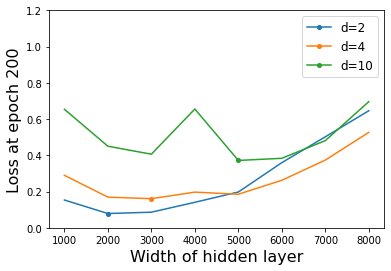

In [55]:
#%%
# nag_loss_total = nag_loss
nag_loss_total = torch.load(path+f"{'nag_total_width'}.pt")
# plt.xscale('log')
# nesterov_r_list = [2, 6, 9]
# width_list = np.arange(1000,8500,500)
# markers_on = [j==3000 for j in y]

plt.figure(figsize=(6,4))
for i in range(len(nesterov_r_list)):
    np.argmin(nag_loss_total[i, :])
    plt.plot(width_list, nag_loss_total[i, :], 
             'o', ls='-', ms=4,
             label = r'd='+str(nesterov_r_list[i]),
             markevery=[j==width_list[np.argmin(nag_loss_total[i, :])] for j in width_list])
plt.xlabel('Width of hidden layer', fontsize=16)
plt.ylabel('Loss at epoch 200', fontsize=16)
# plt.xlim(8e-5, 1e-4)
plt.ylim(0,1.2)
plt.legend(fontsize=12)
plt.savefig(path+'NAG_Width.pdf', bbox_inches = 'tight')
plt.show() 

### NAG v.s epoch

In [65]:
import time
start = time.time()
torch.manual_seed(1)
nag_loss0=NTK_torch(opt_name='nesterov_2',hidden_neuron=3000,epochs=5000,lr=1e-4,nesterov_r=2, save=True)
nag_loss1=NTK_torch(opt_name='nesterov_3',hidden_neuron=3000,epochs=5000,lr=1e-4,nesterov_r=3, save=True)
nag_loss2=NTK_torch(opt_name='nesterov_6',hidden_neuron=3000,epochs=5000,lr=1e-4,nesterov_r=6, save=True)
nag_loss3=NTK_torch(opt_name='nesterov_8',hidden_neuron=3000,epochs=5000,lr=1e-4,nesterov_r=8, save=True)
print('time spent: ', time.time()-start)

Training with nesterov
100 --- 0.73417777
200 --- 0.13559385
300 --- 0.03135373
400 --- 0.00924726
500 --- 0.004154823
600 --- 0.0019290829
700 --- 0.0011561925
800 --- 0.00069377257
900 --- 0.000484411
1000 --- 0.0003015469
1100 --- 0.00024409831
1200 --- 0.00016220285
1300 --- 0.00012714237
1400 --- 0.0001011581
1500 --- 8.531052e-05
1600 --- 6.5483975e-05
1700 --- 5.381722e-05
1800 --- 4.3990265e-05
1900 --- 3.754162e-05
2000 --- 2.8382954e-05
2100 --- 2.6651385e-05
2200 --- 2.0757057e-05
2300 --- 1.8677985e-05
2400 --- 1.7051281e-05
2500 --- 1.4198355e-05
2600 --- 1.3354778e-05
2700 --- 1.1972944e-05
2800 --- 9.133054e-06
2900 --- 9.12547e-06
3000 --- 8.359375e-06
3100 --- 7.2333155e-06
3200 --- 6.4389187e-06
3300 --- 6.0002367e-06
3400 --- 4.7518142e-06
3500 --- 5.031904e-06
3600 --- 4.209608e-06
3700 --- 4.026169e-06
3800 --- 3.5228109e-06
3900 --- 3.587686e-06
4000 --- 3.0131873e-06
4100 --- 2.8236443e-06
4200 --- 2.6465289e-06
4300 --- 2.4006451e-06
4400 --- 2.243491e-06
4500 -

In [22]:
nag_loss0 = torch.load(path+f"{'0.0001nesterov_2'}.pt")
nag_loss1 = torch.load(path+f"{'0.0001nesterov_3'}.pt")
nag_loss2 = torch.load(path+f"{'0.0001nesterov_6'}.pt")
nag_loss3 = torch.load(path+f"{'0.0001nesterov_8'}.pt")
gd_loss = torch.load(path+f"{'0.0001gd'}.pt")

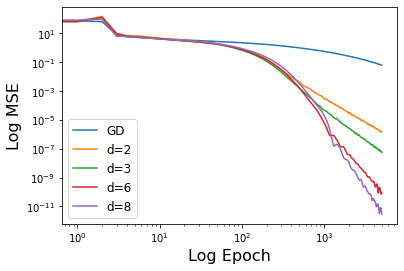

In [52]:
#%%
# plt.figure(figsize=(8,5))
plt.xscale('log')
plt.yscale('log')
plt.plot(gd_loss, label='GD') #NAG08
plt.plot(nag_loss0, label='d=2') #NAG02
plt.plot(nag_loss1, label='d=3') #NAG03
plt.plot(nag_loss2, label='d=6') #NAG06
plt.plot(nag_loss3, label='d=8') #NAG08
plt.xlabel('Log Epoch', fontsize=16)
plt.ylabel('Log MSE', fontsize=16)
plt.legend(fontsize=12)
plt.savefig(path+'NAG_Epoch.pdf', bbox_inches = 'tight')
plt.show()

## Higher momentum

In [8]:
hm_loss0=NTK_torch(opt_name='higherm_0202',hidden_neuron=3000,epochs=5000,lr=1e-4,momentum=0.2, momentum2=0.2, save=True)
hm_loss1=NTK_torch(opt_name='higherm_0205',hidden_neuron=3000,epochs=5000,lr=1e-4,momentum=0.2, momentum2=0.5, save=True)
hm_loss2=NTK_torch(opt_name='higherm_0208',hidden_neuron=3000,epochs=5000,lr=1e-4,momentum=0.2, momentum2=0.8, save=True)

Training with higher momentum
100 --- 1.8374466
200 --- 1.3382971
300 --- 1.0604175
400 --- 0.87833273
500 --- 0.747504
600 --- 0.6484427
700 --- 0.5708051
800 --- 0.5077481
900 --- 0.45524406
1000 --- 0.41096342
1100 --- 0.37300184
1200 --- 0.34014538
1300 --- 0.31147093
1400 --- 0.28624493
1500 --- 0.26390016
1600 --- 0.24405877
1700 --- 0.22630285
1800 --- 0.21031246
1900 --- 0.1958844
2000 --- 0.18283905
2100 --- 0.17095341
2200 --- 0.16008618
2300 --- 0.15013613
2400 --- 0.14100383
2500 --- 0.13262014
2600 --- 0.12489891
2700 --- 0.1177718
2800 --- 0.111188665
2900 --- 0.10508095
3000 --- 0.09940373
3100 --- 0.09411887
3200 --- 0.0892041
3300 --- 0.08461946
3400 --- 0.08033427
3500 --- 0.076317
3600 --- 0.07254326
3700 --- 0.069009624
3800 --- 0.06569563
3900 --- 0.062591285
4000 --- 0.059669405
4100 --- 0.056920536
4200 --- 0.05432718
4300 --- 0.05187997
4400 --- 0.049566217
4500 --- 0.047385473
4600 --- 0.045321904
4700 --- 0.04336516
4800 --- 0.04151695
4900 --- 0.039767228
500

In [53]:
hm_loss0 = torch.load(path+f"{'0.0001higherm_0202'}.pt")
hm_loss1 = torch.load(path+f"{'0.0001higherm_0205'}.pt")
hm_loss2 = torch.load(path+f"{'0.0001higherm_0208'}.pt")

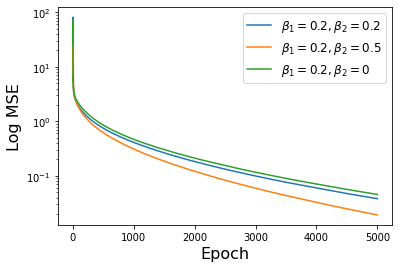

In [54]:
#%%
plt.yscale('log')
plt.plot(hm_loss0, label=r'$\beta_1=0.2, \beta_2=0.2$') #HM0202
plt.plot(hm_loss1, label=r'$\beta_1=0.2, \beta_2=0.5$') #HM0205
#plt.plot(hm_loss2, label='HM0208')
plt.plot(hb_loss0, label=r'$\beta_1=0.2, \beta_2=0$') #HB02
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Log MSE',fontsize=16)
plt.legend(fontsize=12)
plt.savefig(path+'HM.pdf', bbox_inches = 'tight')
plt.show()